In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import math
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM

Using TensorFlow backend.


In [2]:
nyse_data = pd.read_csv("data/all_stocks_2006-01-01_to_2018-01-01.csv")

In [3]:
print(nyse_data.info())
nyse_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93612 entries, 0 to 93611
Data columns (total 7 columns):
Date      93612 non-null object
Open      93587 non-null float64
High      93602 non-null float64
Low       93592 non-null float64
Close     93612 non-null float64
Volume    93612 non-null int64
Name      93612 non-null object
dtypes: float64(4), int64(1), object(2)
memory usage: 5.0+ MB
None


,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,77.76,79.35,77.24,79.11,3117200,MMM
1,2006-01-04,79.49,79.49,78.25,78.71,2558000,MMM
2,2006-01-05,78.41,78.65,77.56,77.99,2529500,MMM
3,2006-01-06,78.64,78.90,77.64,78.63,2479500,MMM
4,2006-01-09,78.50,79.83,78.46,79.02,1845600,MMM


In [4]:
# as a test case, let's take 3M as our example
mmm = nyse_data.loc[nyse_data.Name == "MMM"]

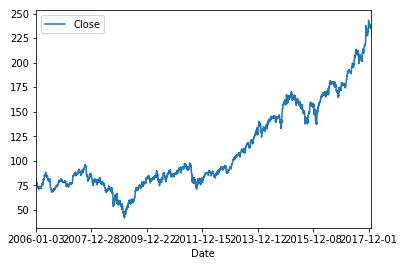

In [5]:
mmm = mmm.sort_values(by='Date')

mmm.plot(x="Date", y="Close")

In [6]:
mmm.index = pd.to_datetime(mmm.Date)

There is definitely a trend with some random noise. Let's see if we can predict the time series with a simle arima model and and then a RNN

In [7]:
# lets predict one month out
num_days = 30
train = mmm[:-num_days]
test = mmm[-num_days:]

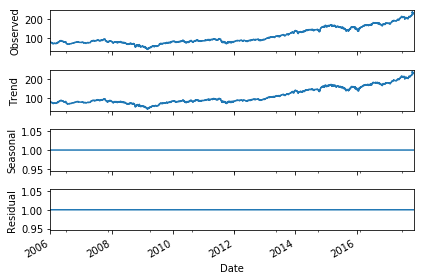

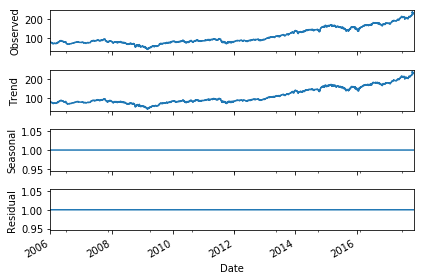

In [8]:
result = seasonal_decompose(train.Close, model='multiplicative', freq=1)
result.plot()

In [9]:
# fit a simple arima model on the training set
stepwise_fit = auto_arima(train.Close.values, start_p=1, start_q=1,
                             max_p=3, max_q=3, m=1,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=10052.801, BIC=10076.811, Fit time=0.987 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=10054.631, BIC=10066.637, Fit time=0.112 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=10050.821, BIC=10068.829, Fit time=0.292 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=10050.886, BIC=10068.894, Fit time=0.349 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=10052.779, BIC=10076.790, Fit time=0.427 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 2.170 seconds


In [14]:
print("ARIMA model order: {}".format(stepwise_fit.order))

ARIMA model order: (1, 1, 0)


In [15]:
arima_preds = stepwise_fit.predict(n_periods=len(test))

# evaluate the accuracy
"ARIMA RMSE: {}".format(math.sqrt(mean_squared_error(test.Close.values, arima_preds)))

'ARIMA RMSE: 8.7048559213332'

## Fit a RNN

loosely based on: https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

In [16]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    
    base_name = df.columns[0]
    col_names = [base_name + '_lag_' + str(i) for i in range(1, lag + 1)]
    
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.insert(0, df)
    df = pd.concat(columns, axis=1)
    
    # add columns names
    df.columns = [base_name] + col_names
    df.dropna(0, inplace=True)
    return df.values

In [17]:
# use the previous 7 days as predictors
shifted = timeseries_to_supervised(mmm.Close, lag=7)
shifted[:5]

array([[77.7 , 78.37, 78.53, 79.02, 78.63, 77.99, 78.71, 79.11],
       [77.5 , 77.7 , 78.37, 78.53, 79.02, 78.63, 77.99, 78.71],
       [77.09, 77.5 , 77.7 , 78.37, 78.53, 79.02, 78.63, 77.99],
       [76.99, 77.09, 77.5 , 77.7 , 78.37, 78.53, 79.02, 78.63],
       [76.91, 76.99, 77.09, 77.5 , 77.7 , 78.37, 78.53, 79.02]])

In [18]:
x_rnn_train, y_rnn_train = shifted[:(-num_days), 1:], shifted[:(-num_days), 0].reshape((-1, 1))
x_rnn_test, y_rnn_test = shifted[-num_days:, 1:], shifted[-num_days:, 0].reshape((-1, 1))

In [19]:
x_rnn_test.shape, x_rnn_train.shape

((30, 7), (2983, 7))

Im going to try this before differencing to see if the network can pick up the trend 

In [20]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

x_rnn_train = x_scaler.fit_transform(x_rnn_train)
y_rnn_train = y_scaler.fit_transform(y_rnn_train)

x_rnn_test = x_scaler.transform(x_rnn_test)
y_rnn_test = y_scaler.transform(y_rnn_test)

The LSTM layer expects input to be in a matrix with the dimensions: [samples, time steps, features].

* __Samples__: These are independent observations from the domain, typically rows of data.
* __Time steps__: These are separate time steps of a given variable for a given observation.
* __Features__: These are separate measures observed at the time of observation.

In [21]:
X = x_rnn_train.reshape(x_rnn_train.shape[0], 1, x_rnn_train.shape[1])
x_rnn_test = x_rnn_test.reshape(x_rnn_test.shape[0], 1, x_rnn_test.shape[1])
X.shape

(2983, 1, 7)

* The shape of the input data must be specified in the LSTM layer using the “batch_input_shape” argument as a tuple that specifies the expected number of observations to read each batch, the number of time steps, and the number of features.
* The number of obs in each batch can be ommited if the batch size is specified when fitting the model.

__important__: It is possible to access the hidden state output for each input time step. This can be done by setting the return_sequences attribute to True when defining the LSTM layer. This is necessary if you'd like to stack LSTM layers (a 3 dimensional output is needed to feed into the next LSTM layer).

A good reference: https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/

In [22]:
model = Sequential()
model.add(LSTM(units=64, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(LSTM(units=128, return_sequences=True))
model.add(LSTM(units=256))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 64)             18432     
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 128)            98816     
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               394240    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 511,745
Trainable params: 511,745
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.fit(x=X, y=y_rnn_train,
         epochs = 15, batch_size=30)

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
2983/2983 [==============================] - 3s 925us/step - loss: 0.0252
Epoch 2/15
2983/2983 [==============================] - 1s 330us/step - loss: 2.5641e-04
Epoch 3/15
2983/2983 [==============================] - 1s 336us/step - loss: 1.8330e-04
Epoch 4/15
2983/2983 [==============================] - 1s 328us/step - loss: 1.4845e-04
Epoch 5/15
2983/2983 [==============================] - 1s 332us/step - loss: 1.2748e-04
Epoch 6/15
2983/2983 [==============================] - 1s 332us/step - loss: 1.2448e-04
Epoch 7/15
2983/2983 [==============================] - 1s 325us/step - loss: 1.2534e-04
Epoch 8/15
2983/2983 [==============================] - 1s 327us/step - loss: 1.2088e-04
Epoch 9/15
2983/2983 [==============================] - 1s 325us/step - loss: 1.2044e-04
Epoch 10/15
2983/2983 [==============================] - 1s 324us/step - loss: 1.1308e-04
Epoch 11/15
2983/2983 [==============================] - 1s 339us

In [24]:
preds = model.predict(x_rnn_test)

# inverse transform the scaling
preds = y_scaler.inverse_transform(preds)

In [26]:
# evaluate the accuracy
print("RNN RMSE: {}".format(math.sqrt(mean_squared_error(test.Close.values, preds.flatten()))))
print("ARIMA RMSE: {}".format(math.sqrt(mean_squared_error(test.Close.values, arima_preds))))

RNN RMSE: 3.1771918494628864
ARIMA RMSE: 8.7048559213332


## Conclusion
Although this was done very naively, being 5 dollars closer on average is a fairly significant difference (especially if we were a trading firm!)